<a href="https://colab.research.google.com/github/kennethgoodman/hugging_face_diffuser_course/blob/main/01_introduction_to_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Setup

In [1]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow

     |████████████████████████████████| 503 kB 12.9 MB/s 
     |████████████████████████████████| 451 kB 59.8 MB/s 
     |████████████████████████████████| 5.8 MB 49.8 MB/s 
     |████████████████████████████████| 191 kB 61.5 MB/s 
     |████████████████████████████████| 53 kB 657 kB/s 
     |████████████████████████████████| 36.0 MB 1.5 MB/s 
     |████████████████████████████████| 182 kB 25.5 MB/s 
     |████████████████████████████████| 212 kB 69.6 MB/s 
     |████████████████████████████████| 132 kB 27.0 MB/s 
     |████████████████████████████████| 127 kB 45.5 MB/s 
     |████████████████████████████████| 7.6 MB 60.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.1 which is incompatible.
db-dtypes 1.0.4 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.1 which is

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [3]:
#@markdown Git LFS
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [4]:
#@markdown Helper Functions
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Download a training dataset

For this example, we'll use a dataset of images from the Hugging Face Hub. Specifically, [this collection of 1000 butterfly pictures](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset). This is a very small dataset, so we've also included commented out lines for a few larger options. If you'd prefer to use your own collection of images, you can also use the commented-out code example to load in pictures from a folder instead.

In [6]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


X shape: torch.Size([8, 3, 32, 32])


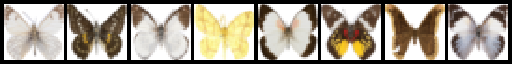

In [7]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

We're sticking to a small dataset with 32 pixel images to keep training times manageable in this notebook.

## Define the Scheduler

Our plan for training is to take these input images and add noise to them, then feed the noisy images to the model. And during inference, we will use the model predictions to iteratively remove noise. In `diffusers`,  these processes are both handled by the **scheduler**. 

The noise schedule determines how much noise is added at different timesteps. Here's how we might create a scheduler using the default settings for 'DDPM' training and sampling (based on the paper ["Denoising Diffusion Probabalistic Models"](https://arxiv.org/abs/2006.11239):

In [8]:
from diffusers import DDPMScheduler

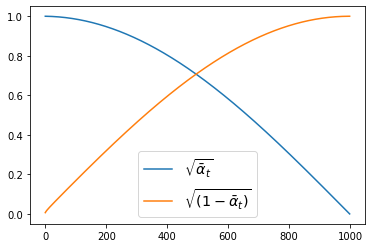

In [18]:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Noisy X shape torch.Size([8, 3, 32, 32])


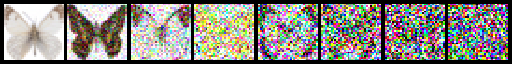

In [19]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

Again, explore the effect of using different noise schedules and parameters here. [This video](https://www.youtube.com/watch?v=fbLgFrlTnGU) does a great job explaining some of the maths above in more detail, and is a great introduction to some of these concepts.

## Step 4: Define the Model

Now we come to the core component: the model itself. 

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers, each of which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downsample path to the corresponding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size. 
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):

In [20]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

When dealing with higher-resolution inputs you may want to use more down and up-blocks, and keep the attention layers only at the lowest resolution (bottom) layers to reduce memory usage. We'll talk later about how you might experiment to find the best settings for your use-case.

In [24]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
assert noisy_xb.shape == model_prediction.shape # same size, model doesn't actually impact size

## Step 5: Create a Training Loop

Time to train! Below is a typical optimization loop in PyTorch, where we run through the data batch by batch and update the parameters of our model each step using an optimizer - in this case the AdamW optimizer with a learning rate of 0.0004. 

For each batch of data, we
- Sample some random timesteps
- Noise the data accordingly
- Feed the noisy data through the model
- Compare the model predictions with the target (i.e. the noise in this case) using mean squared error as our loss function
- Update the model parameters via `loss.backward()` and `optimizer.step()`

During this process we also log the losses over time for later plotting.

NB: This code takes nearly 10 minutes to run - feel free to skip these two cells and use the pretrained model if you are in a hurry. Alternatively, you can explore how reducing the number of channels in each layer via the model definition above can speed things up.

The [official diffusers training example](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) trains a larger model on this dataset at higher resolution, and is a good reference for what a less minimal training loop looks like:

In [25]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:5, loss: 0.14733040425926447
Epoch:10, loss: 0.11221559345722198
Epoch:15, loss: 0.09442108916118741
Epoch:20, loss: 0.08290079119615257
Epoch:25, loss: 0.081226707668975
Epoch:30, loss: 0.07134376000612974


Plotting the loss, we see that the model rapidly improves initially and then continues to get better at a slower rate (which is more obvious if we use a log scale as shown on the right):

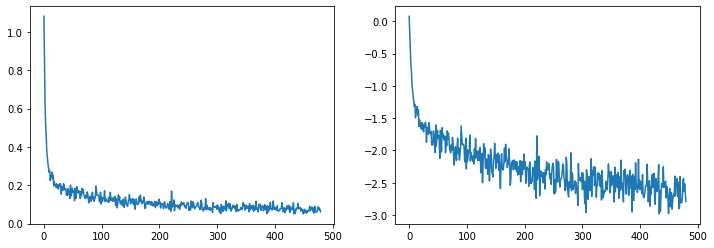

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Step 6: Generate Images

How do we get images with this model?

### Option 1: Creating a pipeline:

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

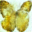

In [ ]:
pipeline_output = image_pipe()
pipeline_output.images[0]

We can save a pipeline to a local folder like so:

In [ ]:
image_pipe.save_pretrained("my_pipeline")

Inspecting the folder contents:

In [ ]:
!ls my_pipeline/

model_index.json  scheduler  unet


The `scheduler` and `unet` subfolders contain everything needed to re-create those components. For example, inside the `unet` folder you'll find the model weights (`diffusion_pytorch_model.bin`) alongside a config file which specifies the UNet architecture. 

In [ ]:
!ls my_pipeline/unet/

config.json  diffusion_pytorch_model.bin


Together, these files contain everything needed to recreate the pipeline. You can manually upload them to the hub to share the pipeline with others, or check out the code to do this via the API in the next section.

### Option 2: Writing a Sampling Loop

If you inspect the forward method of the pipeline you'll be able to see what is happening when we run `image_pipe()`:

In [ ]:
# ??image_pipe.forward

We begin with random noise, and run through the scheduler timesteps from most to least noisy, removing a small amount of noise each step based on the model prediction:

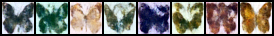

In [ ]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

The `noise_scheduler.step()` function does the maths required to update `sample` appropriately. There are a number of sampling methods - in the next unit we'll see how we can swap in a different sampler to speed up image generation with existing models, and talk more about the theory behind sampling from diffusion models.

## Step 7: Push your model to the Hub

In the example above we saved our pipeline to a local folder. To push our model to the Hub, we will need to model repository to push our files to. We'll determine the repository name from the model ID we want to give our model (feel free to replace the `model_name` with your own choice; it just needs to contain your username, which is what the function `get_full_repo_name()` does):

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'lewtun/sd-class-butterflies-32'

Next, create a model repository on the 🤗 Hub and push our model:

In [ ]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

'https://huggingface.co/lewtun/sd-class-butterflies-32/blob/main/model_index.json'

The last thing to do is create a nice model card so that our butterfly generator can easily be found on the Hub (feel free to expand and edit the description!):

In [ ]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

Now that the model is on the Hub, you can download it from anywhere by using the `from_pretrained()` method of the `DDPMPipeline` as follows"

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

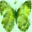

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]

Great it works!

# Scaling up with 🤗 Accelerate

This notebook was made for learning purposes, and as such I tried to keep the code as minimal and clean as possible. Because of this, we omitted some of the things you might want if you were to try training a larger model on much more data, such as multi-GPU support, logging of progress and example images, gradient checkpointing to support larger batch sizes, automatic uploading of models and so on. Thankfully most of these features are available in the example training script [here](https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py).

You can download the file like so:

In [ ]:
!wget https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py

Open up the file and you'll see where the model is defined and what settings are available. I ran the script with the following command:

In [ ]:
# Let's give our new model a name for the Hub
model_name = "sd-class-butterflies-64"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'lewtun/sd-class-butterflies-64'

In [ ]:
!accelerate launch train_unconditional.py \
  --dataset_name="huggan/smithsonian_butterflies_subset" \
  --resolution=64 \
  --output_dir={model_name} \
  --train_batch_size=32 \
  --num_epochs=50 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_warmup_steps=500 \
  --mixed_precision="no"

As before, let's push the model to the Hub and create a nice model card (and feel free to edit it as you wish!):

In [ ]:
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{model_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{model_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{model_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/lewtun/sd-class-butterflies-64/blob/main/README.md'

About 45 minutes later, this is the result:

  0%|          | 0/1000 [00:00<?, ?it/s]

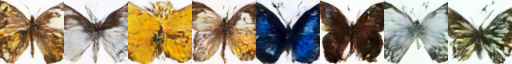

In [ ]:
pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
images = pipeline(batch_size=8).images
make_grid(images)

**Exercise:** See if you can find training/model settings that give good results in as little time as possible, and share your findings with the community. Dig around in the script to see if you can understand the code, and ask for clarification on anything that looks confusing.

# Avenues for Further Exploration

Hopefully this has given you a taste of what you can do with the 🤗 Diffusers library! Some possible next steps:

- Try training an unconditional diffusion model on a new dataset - bonus points if you [create one yourself](https://huggingface.co/docs/datasets/image_dataset). You can find some great image datasets for this task in the [HugGan organization](https://huggingface.co/huggan) on the Hub. Just make sure you downsample them if you don't want to wait a very long time for the model to train!
- Try out DreamBooth to create your own customized Stable Diffusion pipeline using either [this Space](https://huggingface.co/spaces/multimodalart/dreambooth-training) or [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb)
- Modify the training script to explore different UNet hyperparameters (number of layers, channels etc), different noise schedules etc.
- Check out the [Diffusion Models from Scratch](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb) notebook for a different take on the core ideas we've covered in this unit

Good luck, and stay tuned for Unit 2!